<a href="https://colab.research.google.com/github/sayakpaul/Parkinson-s-Disease-Classifier/blob/master/Parkinson_s_Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting Parkinson’s Disease with the help of deep learning

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install "torch==1.4" "torchvision==0.5.0"



Updating fastai...
Done.


In [ ]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Parkinsons'

Mounted at /content/gdrive


In [ ]:
import numpy as np
#conda install -c anaconda pandas
import pandas as pd
#conda install -c conda-forge matplotlib
#conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
import matplotlib.pyplot as plt[]
%matplotlib inline

In [ ]:
#Windows
#root_dir = "/Users/grprksh/Downloads/Abishek/Parkinson-s-Disease-Classifier-master/"

In [ ]:
base_dir

'/content/gdrive/My Drive/Parkinsons'

In [ ]:
# Tesla T4s, Yuhu!
!nvidia-smi

Mon Aug 10 09:17:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
#dataset= os.path.sep.join(["Parkinsons","spiral"])
dataset= os.path.sep.join(["Parkinsons","wave"])
#dataset= os.path.sep.join(["Parkinsons","full"])

In [ ]:
# Setting the path for getting the data
path = root_dir + dataset; path

'/content/gdrive/My Drive/Parkinsons/wave'

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#conda install -c fastai fastai
#conda install -c fastai fastprogress
from fastprogress.fastprogress import master_bar, progress_bar

import fastai
from fastai.vision import *
from fastai.metrics import *

In [ ]:
import numpy as np
np.random.seed(7)

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=128, bs=8).normalize(imagenet_stats)

In [ ]:
data

ImageDataBunch;

Train: LabelList (72 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: /content/gdrive/My Drive/Parkinsons/wave;

Valid: LabelList (30 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
parkinson,parkinson,parkinson,parkinson,parkinson
Path: /content/gdrive/My Drive/Parkinsons/wave;

Test: None

### Looking at the data

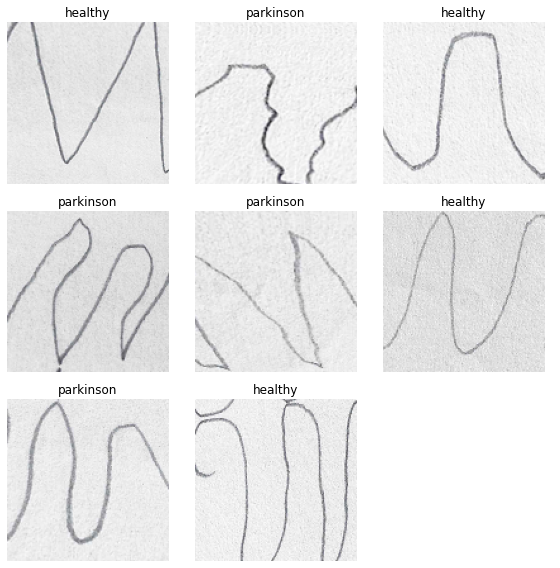

In [ ]:
data.show_batch(rows=3, figsize=(8,8))

### Data labels and distributions

In [ ]:
data.classes

['healthy', 'parkinson']

In [ ]:
data.label_list

LabelLists;

Train: LabelList (72 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
healthy,healthy,healthy,healthy,healthy
Path: /content/gdrive/My Drive/Parkinsons/wave;

Valid: LabelList (30 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
parkinson,parkinson,parkinson,parkinson,parkinson
Path: /content/gdrive/My Drive/Parkinsons/wave;

Test: None

In [ ]:
data.from_df

<bound method ImageDataBunch.from_df of <class 'fastai.vision.data.ImageDataBunch'>>

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


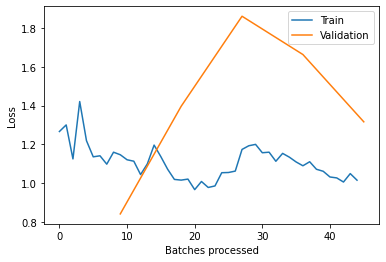

In [ ]:

learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5);
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


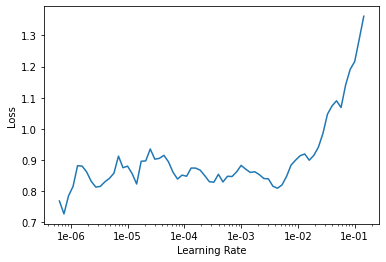

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=1e-04)

In [ ]:
# How about training the last group with a relatively lower learning rate?
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

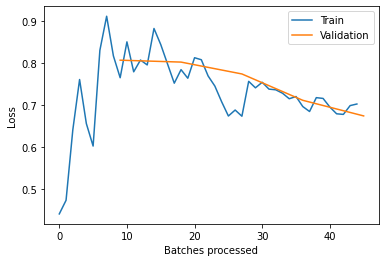

In [ ]:
learn.recorder.plot_losses()

In [ ]:
# Let's save the wait
learn.save('stage-1-rn34')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

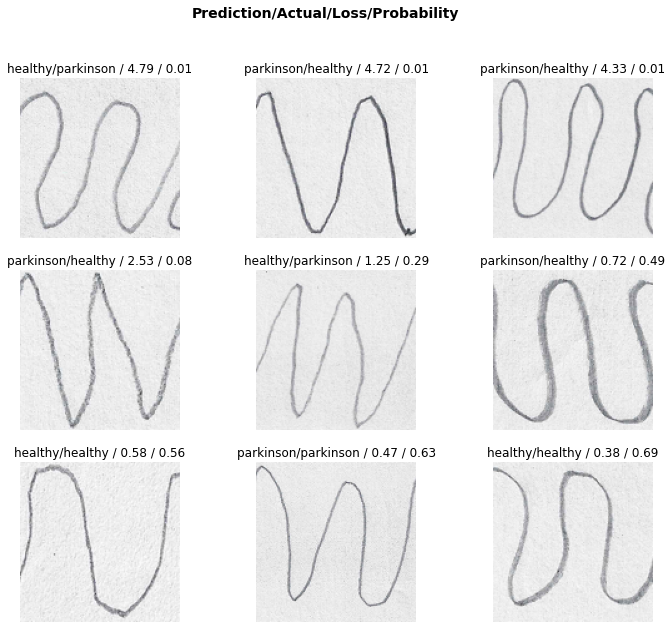

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

**Observation**: I created the `ImageDatabunch` with a size of **128x128**. I think this is indeed confusing the model. The model is unable to explore the pixels in the images due to the reduced size. Let's do it with 256 this time and see if we can push the score and robustness. 

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=256, bs=8).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.load('stage-1-rn34') # Loading the weights of the previous model
learn.fit(5)

The performance improved. Here, we fitted a model which was trained using images of size 128x128. Let's train a fresh model. 

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy).to_fp16()
learn.fit_one_cycle(5)

Did not help much :O (**Note** that we are using the _pre-trained weights_) Let's find the network a good learning rate and also investigate the model training. 

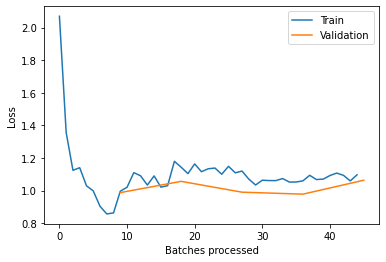

In [ ]:
learn.recorder.plot_losses()

Model's training loss keeps getting down which is a good sign. 

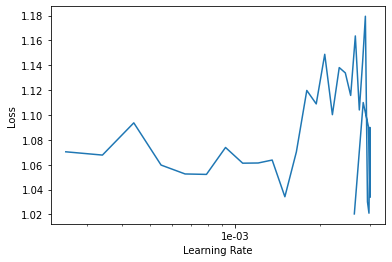

In [ ]:
#learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

In [ ]:
learn.save('rn-34-unfreeze')

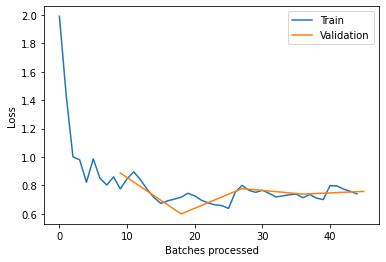

In [ ]:
learn.recorder.plot_losses()

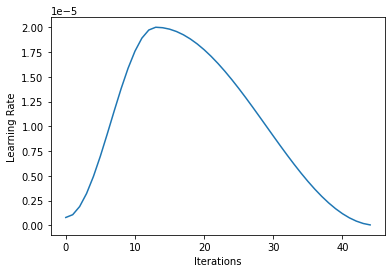

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(3*1e-05, 3*1e-05/5))

In [ ]:
learn.save('stage-2-rn34-256-final')

In [ ]:
learn.export('parkinson-predictor.pkl')

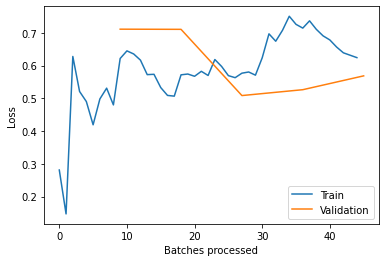

In [ ]:
learn.recorder.plot_losses()

Let's now interpret the model a bit by taking a look at its results, model's top losses and the confusion matrix . 

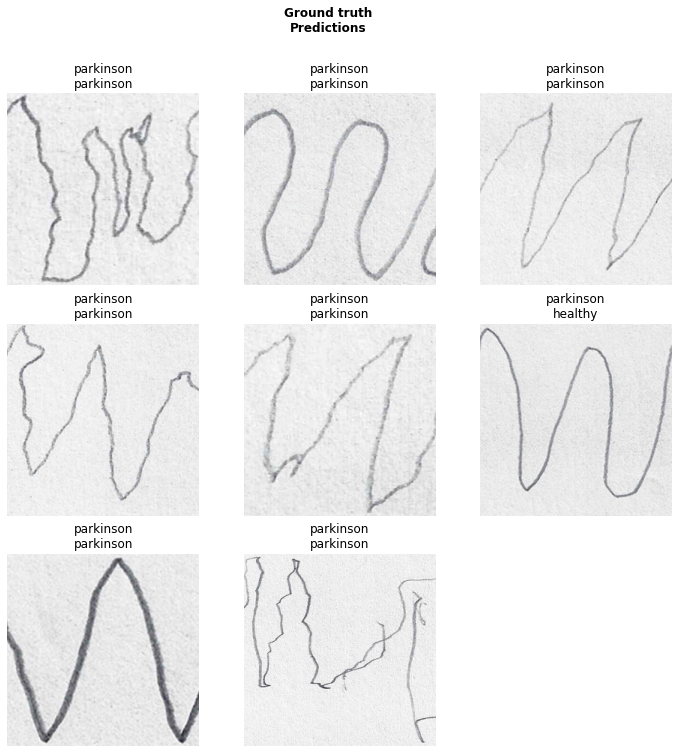

In [ ]:
learn.show_results(rows=3)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

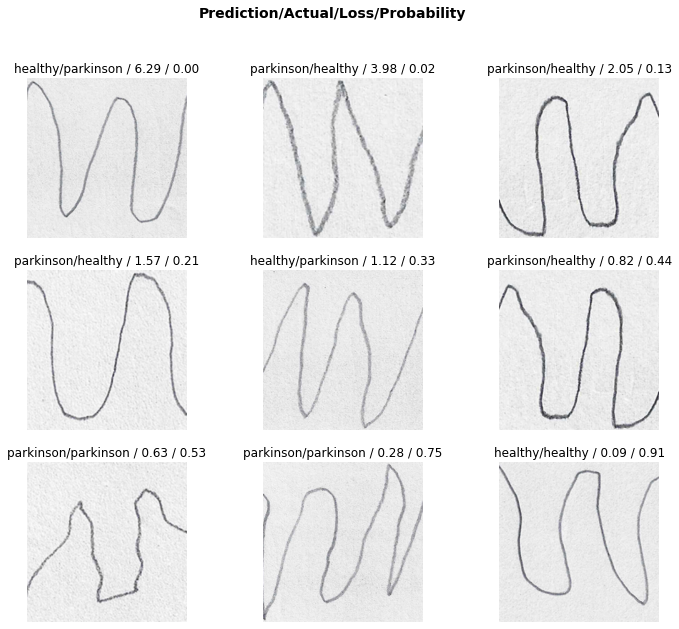

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

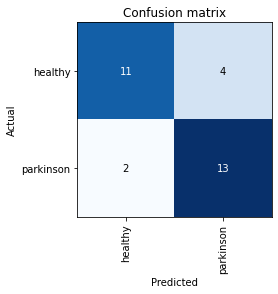

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
cm=interp.confusion_matrix()
cm=cm.reshape(4,)
cm=list(cm)

In [ ]:
(tn, fp, fn, tp)=cm

acc= (tp + tn) / float(sum(cm))
sensitivity = tp / float(tp + fn)
specificity = tn / float(tn + fp)

print('accuracy',acc)
print('sensitivity', sensitivity)
print('specificity', specificity)

accuracy 0.8
sensitivity 0.8666666666666667
specificity 0.7333333333333333


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


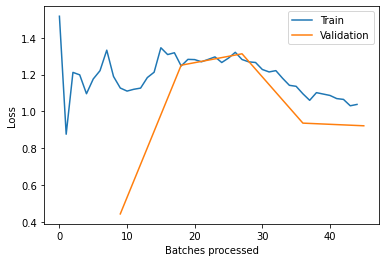

In [ ]:
res50 = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()
res50.fit_one_cycle(5);
res50.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


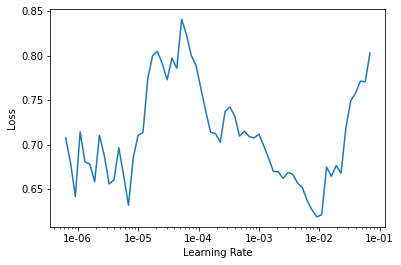

In [ ]:
res50.lr_find()
res50.recorder.plot()

In [ ]:
res50.unfreeze()
res50.fit_one_cycle(5, max_lr=1e-04)

In [ ]:
res50.unfreeze()
res50.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

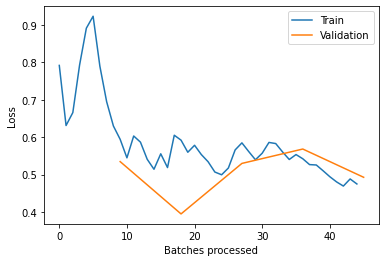

In [ ]:
res50.recorder.plot_losses()

In [ ]:
res50.save('stage-1-rn50')

In [ ]:
interp = ClassificationInterpretation.from_learner(res50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

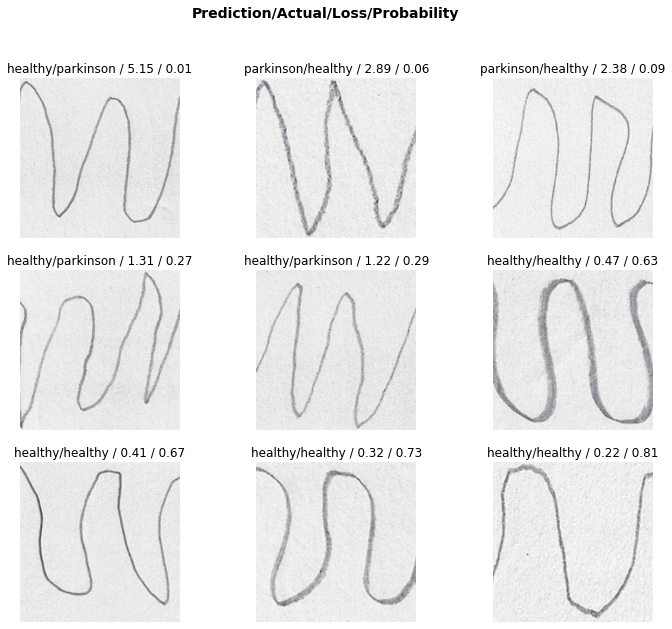

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

In [ ]:
(tn, fp, fn, tp)=cm

acc= (tp + tn) / float(sum(cm))
sensitivity = tp / float(tp + fn)
specificity = tn / float(tn + fp)

print('accuracy',acc)
print('sensitivity', sensitivity)
print('specificity', specificity)

accuracy 0.8
sensitivity 0.8666666666666667
specificity 0.7333333333333333


In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=256, bs=8).normalize(imagenet_stats)

res50 = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()
res50.load('stage-1-rn50') # Loading the weights of the previous model
res50.fit(5)

In [ ]:
res50 = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()
res50.fit_one_cycle(5)

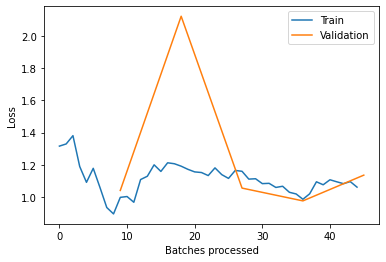

In [ ]:
res50.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


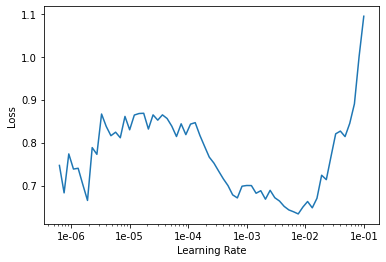

In [ ]:
res50.lr_find()
res50.recorder.plot()

In [ ]:
res50.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

In [ ]:
res50.save('rn-50-unfreeze')

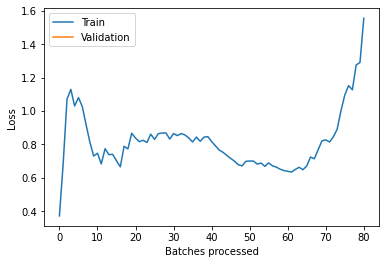

In [ ]:
res50.recorder.plot_losses()

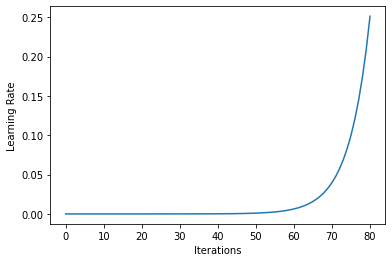

In [ ]:
res50.recorder.plot_lr()

In [ ]:
res50.fit_one_cycle(5, max_lr=slice(3*1e-05, 3*1e-05/5))

In [ ]:
res50.save('stage-2-rn50-256-final')

In [ ]:
res50.export('parkinson-predicto-res50.pkl')

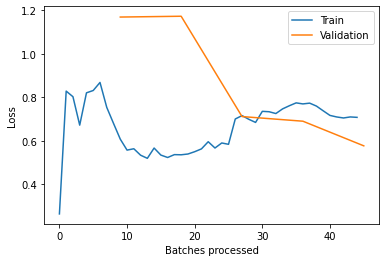

In [ ]:
res50.recorder.plot_losses()

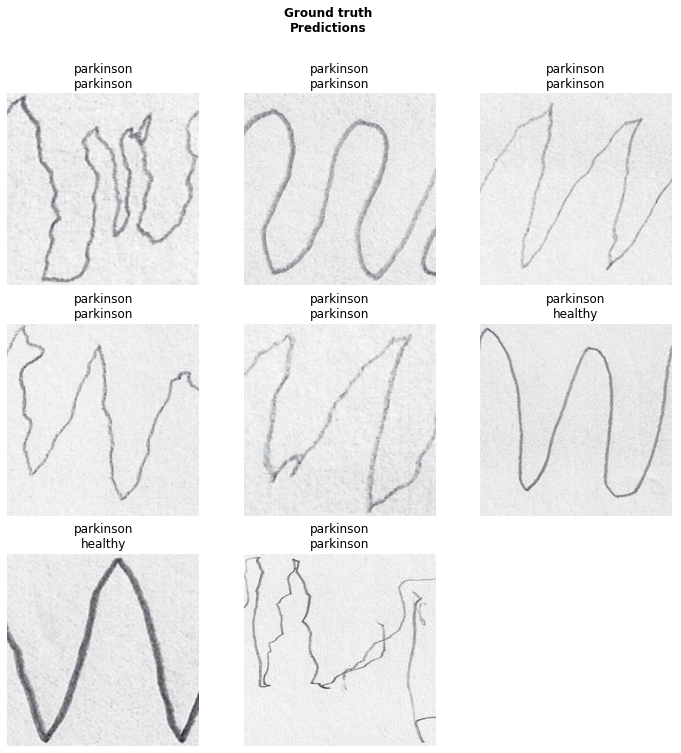

In [ ]:
res50.show_results(rows=3)

In [ ]:
interp = ClassificationInterpretation.from_learner(res50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

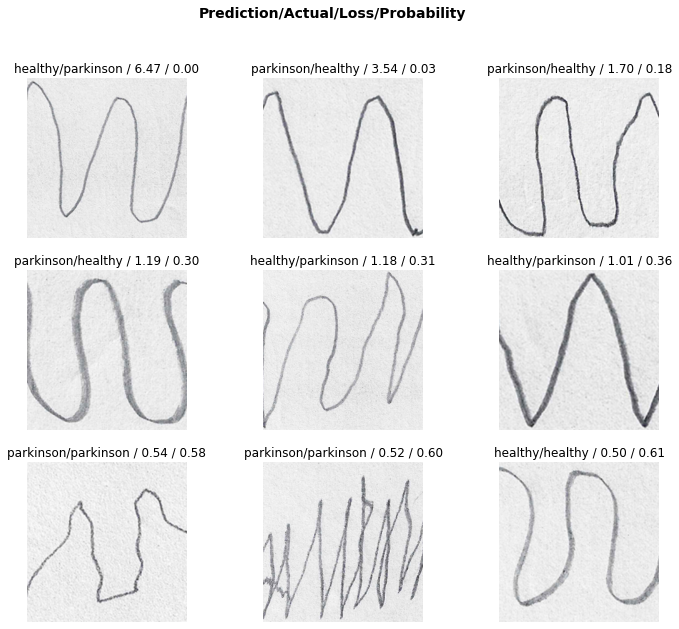

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

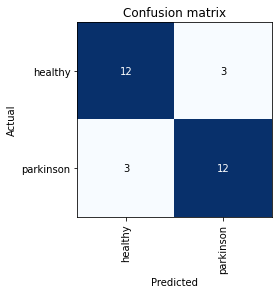

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
cm=interp.confusion_matrix()
cm=cm.reshape(4,)
cm=list(cm)

In [ ]:
(tn, fp, fn, tp)=cm

acc= (tp + tn) / float(sum(cm))
sensitivity = tp / float(tp + fn)
specificity = tn / float(tn + fp)

print('accuracy',acc)
print('sensitivity', sensitivity)
print('specificity', specificity)

accuracy 0.8
sensitivity 0.8
specificity 0.8


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


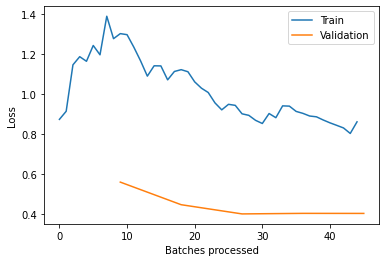

In [ ]:
vgg19= cnn_learner(data, models.vgg19_bn, metrics=accuracy).to_fp16()
vgg19.fit_one_cycle(5);
vgg19.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


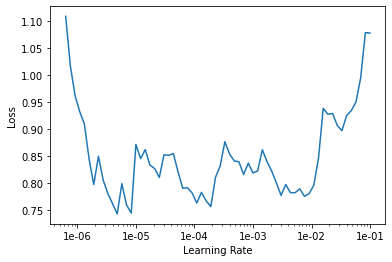

In [ ]:
vgg19.lr_find()
vgg19.recorder.plot()

In [ ]:
vgg19.unfreeze()
vgg19.fit_one_cycle(5, max_lr=1e-04)

In [ ]:
vgg19.unfreeze()
vgg19.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

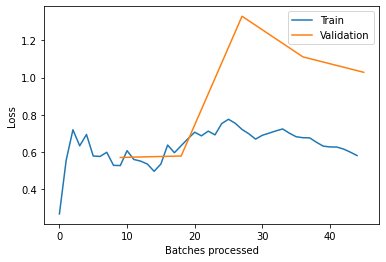

In [ ]:
vgg19.recorder.plot_losses()

In [ ]:
vgg19.save('stage-1-vgg19')

In [ ]:
interp = ClassificationInterpretation.from_learner(vgg19)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

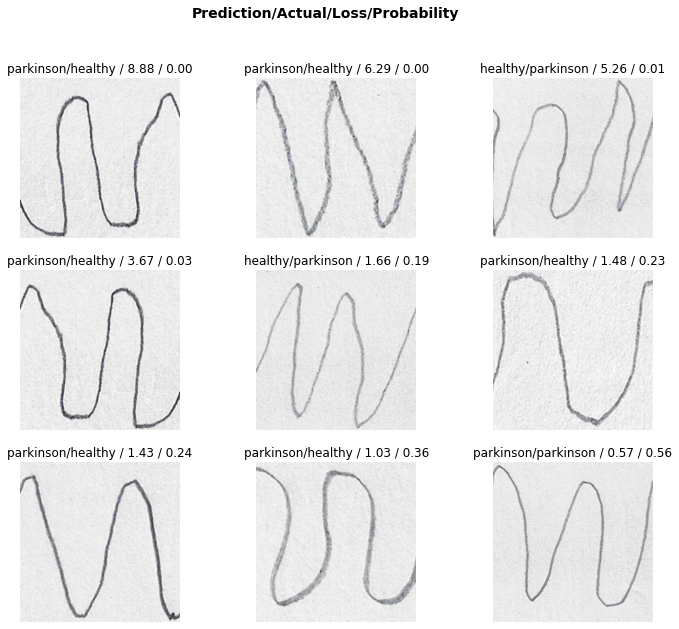

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid='test',
                                  size=224, bs=8).normalize(imagenet_stats)

vgg19 = cnn_learner(data, models.vgg19_bn, metrics=accuracy).to_fp16()
vgg19.load('stage-1-vgg19') # Loading the weights of the previous model
vgg19.fit(5)

In [ ]:
vgg19 = cnn_learner(data, models.vgg19_bn, metrics=accuracy).to_fp16()
vgg19.fit_one_cycle(5)

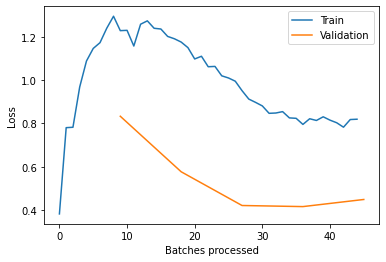

In [ ]:
vgg19.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


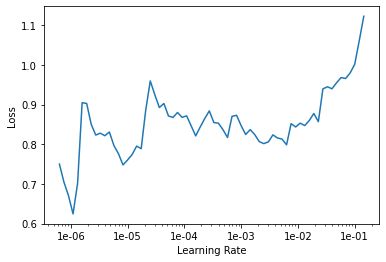

In [ ]:
vgg19.lr_find()
vgg19.recorder.plot()

In [ ]:
vgg19.unfreeze()
vgg19.fit_one_cycle(5, max_lr=slice(1e-04, 1e-04/5))

In [ ]:
vgg19.save('vgg-19-unfreeze')

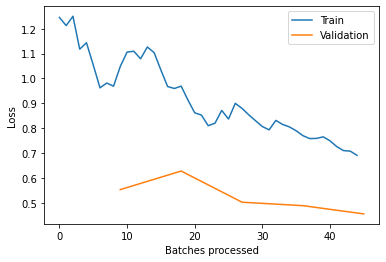

In [ ]:
vgg19.recorder.plot_losses()

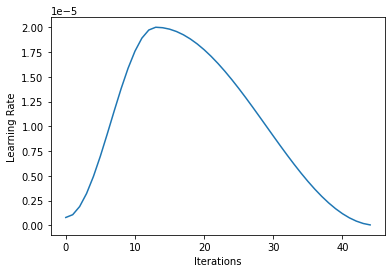

In [ ]:
vgg19.recorder.plot_lr()

In [ ]:
vgg19.fit_one_cycle(5, max_lr=slice(3*1e-05, 3*1e-05/5))

In [ ]:
vgg19.save('stage-2-vgg19-256-final')

In [ ]:
vgg19.export('parkinson-predicto-vgg19.pkl')

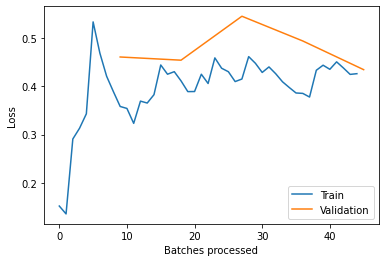

In [ ]:
vgg19.recorder.plot_losses()

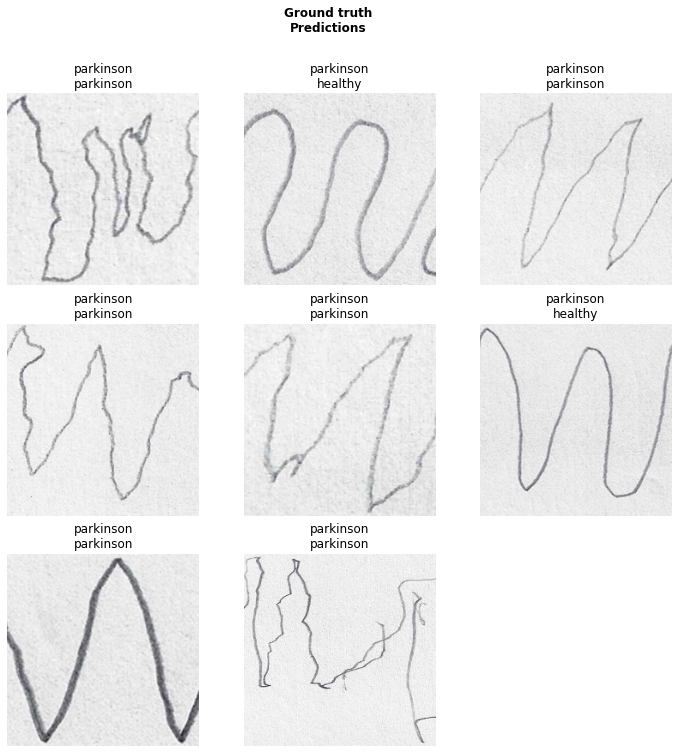

In [ ]:
vgg19.show_results(rows=3)

In [ ]:
interp = ClassificationInterpretation.from_learner(vgg19)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

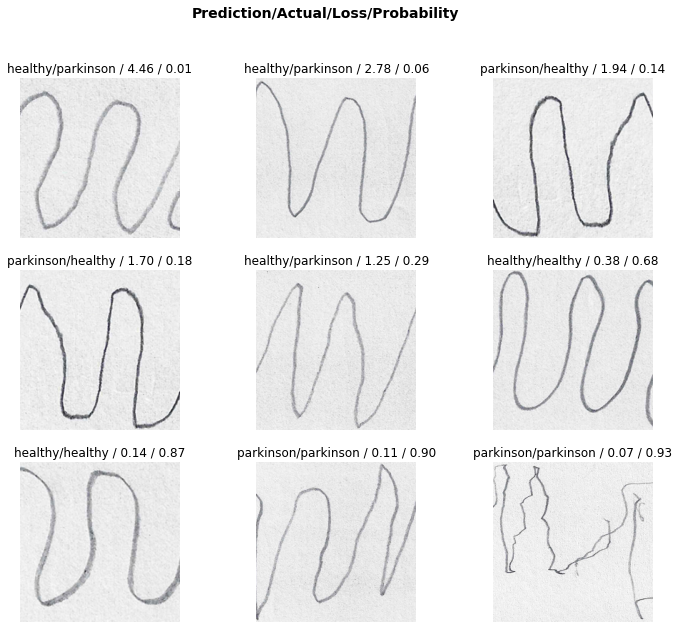

In [ ]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

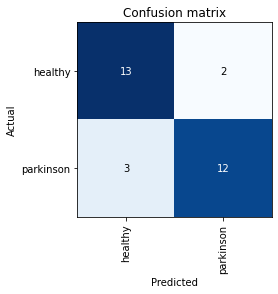

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
cm=interp.confusion_matrix()
cm=cm.reshape(4,)
cm=list(cm)

In [ ]:
(tn, fp, fn, tp)=cm

acc= (tp + tn) / float(sum(cm))
sensitivity = tp / float(tp + fn)
specificity = tn / float(tn + fp)

print('accuracy',acc)
print('sensitivity', sensitivity)
print('specificity', specificity)

accuracy 0.8333333333333334
sensitivity 0.8
specificity 0.8666666666666667
